# IMPORT

In [4]:
# Model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR 

# Others
import pandas as pd
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import os
import sys
import json

from training.train import train
from preprocessing.preprocessing import *
from dataset.thermal_dataset import thermal_dataset
from utils.csv_utils import *
from models.complete_model import complete_model
from testing.test import test
prefix = '.'
    
pd.set_option('display.max_columns', None)

**Reproducibility and Device Setting**

In [5]:
# Set a seed for reproducibility purposes
seed = 46
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

# Set the device (cuda for Nvidia GPUs, mps for M1, M2 .. Apple Silicon)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# Test

In [6]:

# List of result paths to test
result_paths = [
    "/results mandelli/lstm_encoder/autoweighted",
    "/results mandelli/lstm_encoder/median",
    "/results mandelli/lstm_encoder/average",
    "/results mandelli/lstm_encoder/minmax-auto-weighted"
]
marker = ['o', '^', 's', 'p', 'P']
# Loss function
loss_fn = nn.MSELoss()

# Dictionary to store results for each model
all_results = []

i= 0

# Iterate over each result path
for result_path in result_paths:
    model_path = prefix + result_path + '/model.pt'

    # Read hyperparameters
    with open(prefix + result_path + '/hyperparam.json', 'r') as f:
        hyperparams = json.load(f)

    if hyperparams['norm']:
        X = np.load(prefix + '/data/X' + 'testing' + str(hyperparams['file']) + '.npy')
        Y = np.load(prefix + '/data/Y' + str(hyperparams['window_size']) + 'testing' + str(hyperparams['file']) + '.npy')
    else:
        X = np.load(prefix + '/data/X' + 'testing' + str(hyperparams['file']) + '.npy')
        Y = np.load(prefix + '/data/Y' + str(hyperparams['window_size']) + 'testing' + str(hyperparams['file']) + '.npy')

    print('X', X)
    print('Y', Y)
    datasetTest = thermal_dataset((X, Y), hyperparams['timesteps'], device)
    loaderTest = DataLoader(datasetTest, shuffle=True, batch_size=hyperparams['batch_size'])

    # Section in which we reinitialize the model for testing depending on the hyperparameters.json and ensemble.json (if present) in the directories of results
    # Read Ensemble models data (if complete = True)
    if hyperparams['ensemble'] == True:
        with open(prefix + result_path + '/ensemble.json', 'r') as f:
            model_dict = json.load(f)
        with open(prefix + result_path + '/autoencoder.json', 'r') as f:
            autoencoder_dict = json.load(f)
        # Read Ensemble model parameters and initialize the model
        if hyperparams['extractor_type'] == 'conv':
            model = complete_model(model_dict=model_dict,
                                   device=device,
                                   autoencoder_dim=autoencoder_dict['in_kern_out'],
                                   pooling_kernel_size=autoencoder_dict['pooling_kernel_size'],
                                   padding=autoencoder_dict['padding'],
                                   pooling=autoencoder_dict['pooling'],
                                   scale_factor=autoencoder_dict['scale_factor'],
                                   upsample_mode=autoencoder_dict['upsample_mode'],
                                   dropout=autoencoder_dict['dropout'],
                                   mode=hyperparams['mode'],
                                   heterogeneous=hyperparams['heterogeneous'],
                                   timesteps=hyperparams['timesteps'],
                                   norm=hyperparams['norm']
                                   ).to(device)

        elif 'lstm' in hyperparams['extractor_type']:
            model = complete_model(
                model_dict=model_dict,
                device=device,
                timesteps=hyperparams['timesteps'],
                lstm_layers=autoencoder_dict['lstm_layers'],
                autoencoder_dim=autoencoder_dict['in_hidd'],
                dropout=autoencoder_dict['dropout'],
                extractor_type=hyperparams['extractor_type'],
                heterogeneous=hyperparams['heterogeneous'],
                norm=hyperparams['norm'],
                mode=hyperparams['mode']
            ).to(device)

    print(hyperparams)
    # print("state_dict",model.state_dict().keys())

    autoencoder = hyperparams['extractor_type'] == 'conv' or hyperparams['extractor_type'] == 'lstm_autoencoder'
    print(hyperparams['extractor_type'] == 'conv' or hyperparams['extractor_type'] == 'lstm_autoencoder')

    test_model_metrics, test_autoencoder_metrics, loss_model_avg, loss_autoencoder_avg, total_inference_time, inference_time_avg, y_true_list, y_pred_list, x_true_list, x_pred_list = test(
        model=model,
        model_path=model_path,
        test_dataloader=loaderTest,
        loss_fn=loss_fn,
        complete=hyperparams['ensemble'],
        autoencoder=autoencoder,
        autoencoder_only=True,
        device=device
    )
    
    path = prefix + result_path  # type ./results/ensemble_batch_256
    
    with open (path + '/train_model_metrics.json', 'r') as f:
        train_metrics = json.load(f)
    with open (path + '/valid_model_metrics.json', 'r') as f:
        valid_metrics = json.load(f)
    i += 1
    # Store results for the current model
    model_results = {
        'result_path': result_path,
        'test_model_metrics': test_model_metrics,
        'test_autoencoder_metrics': test_autoencoder_metrics,
        'loss_model_avg': loss_model_avg,
        'loss_autoencoder_avg': loss_autoencoder_avg,
        'total_inference_time': total_inference_time,
        'inference_time_avg': inference_time_avg,
        'y_true_list': y_true_list,
        'y_pred_list': y_pred_list,
        'x_true_list': x_true_list,
        'x_pred_list': x_pred_list,
        'train_metrics': train_metrics,
        'valid_metrics': valid_metrics,
        'hyperparams': hyperparams,
        'autoencoder': autoencoder,
        'marker':marker[i]
        
    }
    all_results.append(model_results)

    # train_val = True
    '''
    print('Legend metrics:[X1,Y1,Z1]')
    print("Test Model metrics:")
    print(f"rmse: {test_model_metrics['rmse'][0]} , mae: {test_model_metrics['mae'][0]}, r2: {test_model_metrics['r2'][0]}")
    print("Reference metrics(wrt. 0):")
    print(f"rmse: {test_model_metrics['rmse_ref'][0]} , mae: {test_model_metrics['mae_ref'][0]}, r2: {test_model_metrics['r2_ref'][0]}")
    if autoencoder:
        print("Test Autoencoder metrics:")
        print(f"rmse: {test_autoencoder_metrics['rmse'][0]} , mae: {test_autoencoder_metrics['mae'][0]}, r2: {test_autoencoder_metrics['r2'][0]}")
    print("Others:")
    print(f"Model Average Loss: {loss_model_avg}, Autoencoder Average Loss: {loss_autoencoder_avg}, Total Inference Time (All Dataset): {total_inference_time}, Average Inference Time: {inference_time_avg}")
    if hyperparams['ensemble'] == True:
        if not 'NoOpModule' in str(type(model.ensemble)):
            print(f"Weights of the Ensemble models: {model.ensemble.weights.cpu().tolist()}")
        if hyperparams['mode'] == 'auto-weighted':
            with open(model_path[:-8] + '/weights.json', 'w') as file:
                json.dump(model.ensemble.weights.cpu().tolist(), file)
'''

X [[2103. 2134. 2145. 2159.]
 [2103. 2129. 2146. 2158.]
 [2103. 2130. 2147. 2157.]
 ...
 [2099. 2138. 2131. 2135.]
 [2099. 2138. 2132. 2137.]
 [2098. 2139. 2132. 2135.]]
Y [[-0.00051967  0.00128181  0.00348477]
 [-0.0007013   0.00049013  0.00329359]
 [-0.00111148 -0.00047101  0.0035543 ]
 ...
 [ 0.000909   -0.0006761  -0.00069522]
 [ 0.00125834 -0.00072737 -0.00032154]
 [ 0.00130614 -0.00058746 -0.00045189]]
Extractor type: LSTM Encoder
Autoencoder Summary: lstm_encoder(
  (lstm_layers): ModuleList(
    (0): lstm(
      (lstm): LSTM(4, 2, num_layers=2, batch_first=True, dropout=0.15)
    )
  )
)
Ensemble Model Summary: ModuleList(
  (0): mlp(
    (linear_layers): ModuleList(
      (0): Linear(in_features=403, out_features=604, bias=True)
      (1): Linear(in_features=604, out_features=201, bias=True)
      (2): Linear(in_features=201, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=67, bias=True)
      (4): Linear(in_features=67, out_features=50, bias=True)

/home/paolo/uni/magistrale/Napoli/eai-project/models/complete_model.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=torch.de

X [[2103. 2134. 2145. 2159.]
 [2103. 2129. 2146. 2158.]
 [2103. 2130. 2147. 2157.]
 ...
 [2099. 2138. 2131. 2135.]
 [2099. 2138. 2132. 2137.]
 [2098. 2139. 2132. 2135.]]
Y [[-0.00051967  0.00128181  0.00348477]
 [-0.0007013   0.00049013  0.00329359]
 [-0.00111148 -0.00047101  0.0035543 ]
 ...
 [ 0.000909   -0.0006761  -0.00069522]
 [ 0.00125834 -0.00072737 -0.00032154]
 [ 0.00130614 -0.00058746 -0.00045189]]
Extractor type: LSTM Encoder
Autoencoder Summary: lstm_encoder(
  (lstm_layers): ModuleList(
    (0): lstm(
      (lstm): LSTM(4, 2, num_layers=2, batch_first=True, dropout=0.15)
    )
  )
)
Ensemble Model Summary: ModuleList(
  (0): mlp(
    (linear_layers): ModuleList(
      (0): Linear(in_features=403, out_features=604, bias=True)
      (1): Linear(in_features=604, out_features=201, bias=True)
      (2): Linear(in_features=201, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=67, bias=True)
      (4): Linear(in_features=67, out_features=50, bias=True)

/home/paolo/uni/magistrale/Napoli/eai-project/models/complete_model.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=torch.de

X [[2103. 2134. 2145. 2159.]
 [2103. 2129. 2146. 2158.]
 [2103. 2130. 2147. 2157.]
 ...
 [2099. 2138. 2131. 2135.]
 [2099. 2138. 2132. 2137.]
 [2098. 2139. 2132. 2135.]]
Y [[-0.00051967  0.00128181  0.00348477]
 [-0.0007013   0.00049013  0.00329359]
 [-0.00111148 -0.00047101  0.0035543 ]
 ...
 [ 0.000909   -0.0006761  -0.00069522]
 [ 0.00125834 -0.00072737 -0.00032154]
 [ 0.00130614 -0.00058746 -0.00045189]]
Extractor type: LSTM Encoder
Autoencoder Summary: lstm_encoder(
  (lstm_layers): ModuleList(
    (0): lstm(
      (lstm): LSTM(4, 2, num_layers=2, batch_first=True, dropout=0.15)
    )
  )
)
Ensemble Model Summary: ModuleList(
  (0): mlp(
    (linear_layers): ModuleList(
      (0): Linear(in_features=403, out_features=604, bias=True)
      (1): Linear(in_features=604, out_features=201, bias=True)
      (2): Linear(in_features=201, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=67, bias=True)
      (4): Linear(in_features=67, out_features=50, bias=True)

/home/paolo/uni/magistrale/Napoli/eai-project/models/complete_model.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=torch.de

X [[2103. 2134. 2145. 2159.]
 [2103. 2129. 2146. 2158.]
 [2103. 2130. 2147. 2157.]
 ...
 [2099. 2138. 2131. 2135.]
 [2099. 2138. 2132. 2137.]
 [2098. 2139. 2132. 2135.]]
Y [[-0.00051967  0.00128181  0.00348477]
 [-0.0007013   0.00049013  0.00329359]
 [-0.00111148 -0.00047101  0.0035543 ]
 ...
 [ 0.000909   -0.0006761  -0.00069522]
 [ 0.00125834 -0.00072737 -0.00032154]
 [ 0.00130614 -0.00058746 -0.00045189]]
Extractor type: LSTM Encoder
Autoencoder Summary: lstm_encoder(
  (lstm_layers): ModuleList(
    (0): lstm(
      (lstm): LSTM(4, 2, num_layers=2, batch_first=True, dropout=0.15)
    )
  )
)
Ensemble Model Summary: ModuleList(
  (0): mlp(
    (linear_layers): ModuleList(
      (0): Linear(in_features=403, out_features=604, bias=True)
      (1): Linear(in_features=604, out_features=201, bias=True)
      (2): Linear(in_features=201, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=67, bias=True)
      (4): Linear(in_features=67, out_features=50, bias=True)

/home/paolo/uni/magistrale/Napoli/eai-project/models/complete_model.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=torch.de

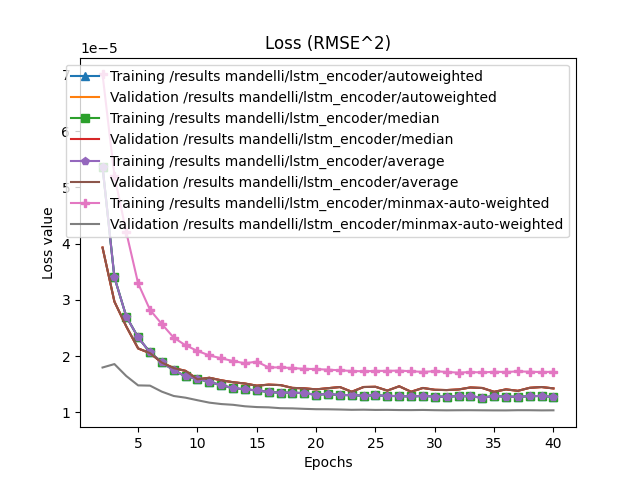

In [7]:


# Load the dictionaries plot the first 40 epochs


# Initialize a list of epochs [1,2,3, ...] for the plots x-axis
epochs = list(range(2, 41))

# Compute training loss as the square of rmse for each element because loss = mse
# Both for training and validation
training_loss = train_metrics['loss']
valid_loss = valid_metrics['loss'][1:40]

fig1, ax1 = plt.subplots()
for result in all_results:
    train_metrics = result['train_metrics']
    valid_metrics = result['valid_metrics']
    training_loss = train_metrics['loss'][1:40]
    valid_loss = valid_metrics['loss'][1:40]
    ax1.plot(epochs, training_loss, label=f"Training {result['result_path']}", marker=result['marker'])
    ax1.plot(epochs, valid_loss, label=f"Validation {result['result_path']}", linestyle='-')

ax1.set_title('Loss (RMSE^2)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss value')
ax1.legend()

plt.savefig(path+'/loss.png')  # Save the figure to the specified path
plt.show()

In [8]:
#print(len(x_pred_list[0][0]))
if autoencoder:
#list is made like [number of sample windows][number of sensors][number of timesteps] [7472][3][199]
    x_pred_sensor_1 = x_pred_list[0][0].copy()
    x_pred_sensor_2 = x_pred_list[0][1].copy()
    x_pred_sensor_3 = x_pred_list[0][2].copy()
    x_pred_sensor_4 = x_pred_list[0][3].copy()
    # we unroll the sliding windows to get the predictions as a continuous list because the windows are overlapped
    x_pred_sensor_1 += [x_pred[0][-1] for x_pred in x_pred_list[1:]]
    x_pred_sensor_2 += [x_pred[1][-1] for x_pred in x_pred_list[1:]]
    x_pred_sensor_3 += [x_pred[2][-1] for x_pred in x_pred_list[1:]]
    x_pred_sensor_4 += [x_pred[3][-1] for x_pred in x_pred_list[1:]]

    x_true_sensor_1 = x_true_list[0][0].copy() 
    x_true_sensor_2 = x_true_list[0][1].copy()
    x_true_sensor_3 = x_true_list[0][2].copy()
    x_true_sensor_4 = x_true_list[0][3].copy()
    # we unroll the sliding windows to get the predictions as a continuous list because the windows are overlapped
    x_true_sensor_1 += [x_true[0][-1] for x_true in x_true_list[1:]]
    x_true_sensor_2 += [x_true[1][-1] for x_true in x_true_list[1:]]
    x_true_sensor_3 += [x_true[2][-1] for x_true in x_true_list[1:]]
    x_true_sensor_4 += [x_true[3][-1] for x_true in x_true_list[1:]]

./results mandelli/lstm_encoder/minmax-auto-weighted/mae.png


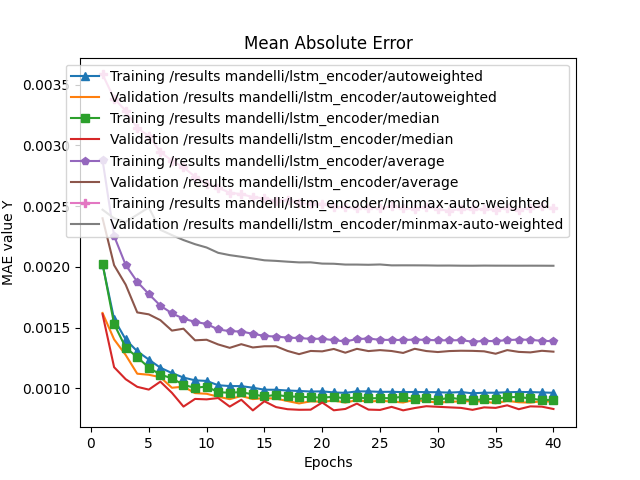

In [9]:
path = prefix + result_path  # type ./results/ensemble_batch_256

# Load the dictionaries
with open (path + '/train_model_metrics.json', 'r') as f:
    train_metrics = json.load(f)
with open (path + '/valid_model_metrics.json', 'r') as f:
    valid_metrics = json.load(f)

# Initialize a list of epochs [1,2,3, ...] for the plots x-axis
epochs = list(range(1, 41))

fig2, ax2 = plt.subplots()

for result in all_results:
    train_metrics = result['train_metrics']['mae'][1:41]
    valid_metrics = result['valid_metrics']['mae'][1:41]
    ax2.plot(epochs, [mae[1] for mae in train_metrics], label=f"Training {result['result_path']}", marker=result['marker'])
    ax2.plot(epochs, [mae[1] for mae in valid_metrics], label=f"Validation {result['result_path']}", linestyle='-')
ax2.set_title('Mean Absolute Error')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE value Y')
ax2.legend()
print(path + '/mae.png')
plt.savefig(path + '/mae.png')  # Save the figure to the specified path
plt.show()

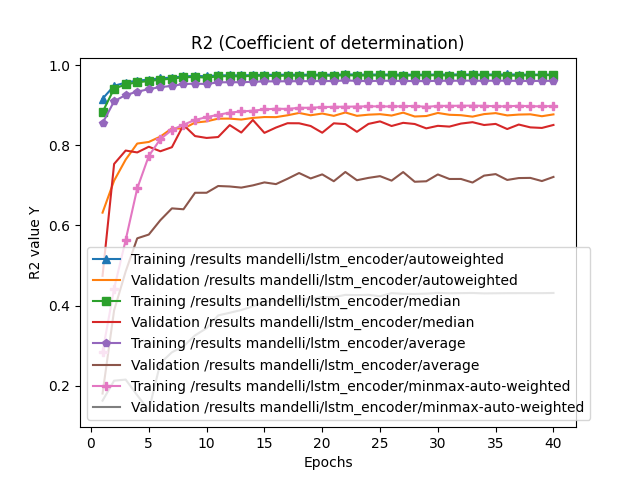

In [10]:
path = prefix + result_path  # type ./results/ensemble_batch_256

# Load the dictionaries
with open (path + '/train_model_metrics.json', 'r') as f:
    train_metrics = json.load(f)
with open (path + '/valid_model_metrics.json', 'r') as f:
    valid_metrics = json.load(f)

# Initialize a list of epochs [1,2,3, ...] for the plots x-axis
epochs = list(range(1, 41))

fig3, ax3 = plt.subplots()

for result in all_results:
    train_metrics = result['train_metrics']['r2'][1:41]
    valid_metrics = result['valid_metrics']['r2'][1:41]
    ax3.plot(epochs, [r2[1] for r2 in train_metrics], label=f"Training {result['result_path']}", marker=result['marker'])
    ax3.plot(epochs, [r2[1] for r2 in valid_metrics], label=f"Validation {result['result_path']}", linestyle='-')
ax3.set_title('R2 (Coefficient of determination)')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('R2 value Y')
plt.legend()

plt.savefig(path + '/r2.png')  # Save the figure to the specified path
plt.show()

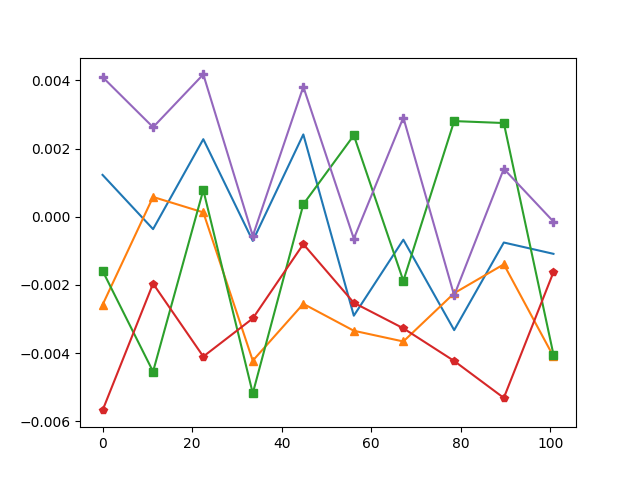

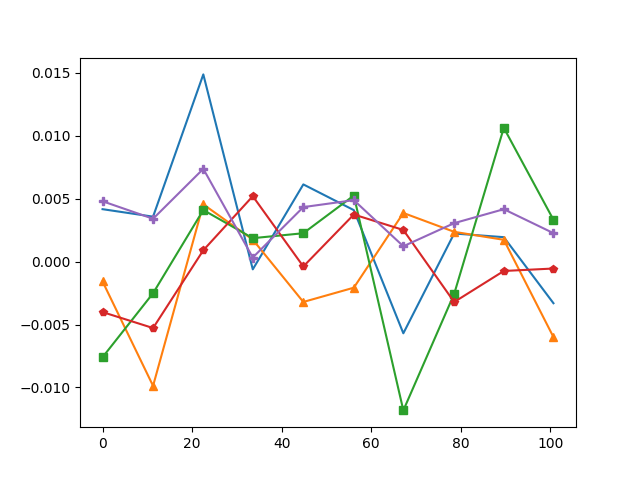

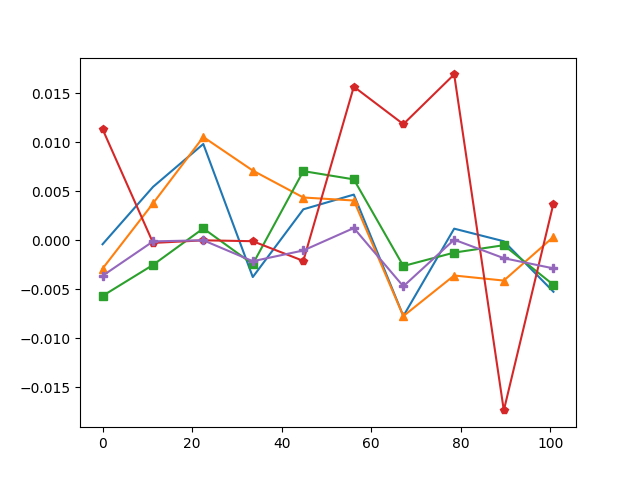

In [23]:
path = prefix + result_path

# Plot X1, Y1, Z1 Sequences
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()
fig6, ax6 = plt.subplots()

time_since_first = pd.read_csv(f"time_since_first_{result['hyperparams']['file']}.csv", header=0, names=['time_since_first'])
time_since_first['time_since_first'] = pd.to_timedelta(time_since_first['time_since_first'])
time_since_first['time_since_first'] = time_since_first['time_since_first'].dt.total_seconds()
time_since_first = time_since_first.squeeze().to_numpy()

# Create the lists of X1, Y1, Z1 true values to plot
x1_true = [x[0] for x in y_true_list][0:10]
y1_true = [y[1] for y in y_true_list][0:10]
z1_true = [z[2] for z in y_true_list][0:10]
t = time_since_first[:len(x1_true)][0:10]

ax4.plot(t, x1_true)#, label="Ground Truth")
ax5.plot(t, y1_true)#, label="Ground Truth")
ax6.plot(t, z1_true)#, label="Ground Truth")

for result in all_results:
    y_pred_list = result['y_pred_list']


    # Create the lists of X1, Y1, Z1 predicted values to plot
    x1_pred = [x[0] for x in y_pred_list][0:10]
    y1_pred = [y[1] for y in y_pred_list][0:10]
    z1_pred = [z[2] for z in y_pred_list][0:10]

    # Create x-axis
    ax4.plot(t, x1_pred, marker=result['marker'])#, label=f"Prediction {result['result_path'][18:]}")
    ax5.plot(t, y1_pred, marker=result['marker'])#, label=f"Prediction {result['result_path'][18:]}")
    ax6.plot(t, z1_pred, marker=result['marker'])#, label=f"Prediction {result['result_path'][18:]}")


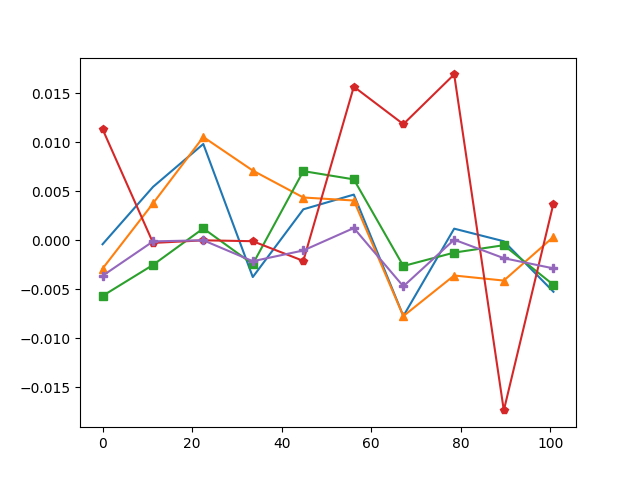

In [12]:
ax4.set_title('X1 Sequence')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('X1 [µm/s]')
ax4.legend()
plt.savefig(path + 'X1_comparison.png')  # Save the figure
plt.show()

./results mandelli/lstm_encoder/minmax-auto-weightedY1_comparison.png


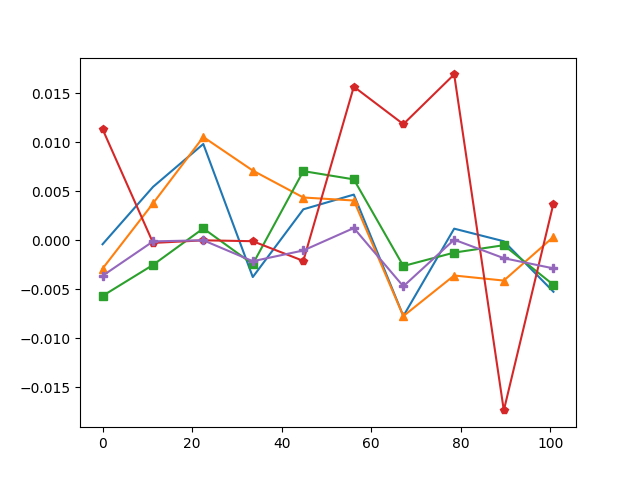

In [13]:

ax5.set_title('Y1 Sequence')
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('Y1 [µm/s]')
ax5.legend()
print(path + 'Y1_comparison.png')
plt.savefig(path + 'Y1_comparison.png')  # Save the figure
plt.show()

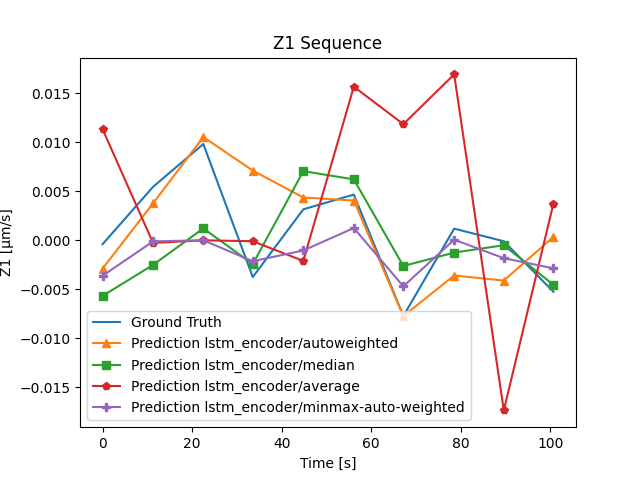

In [14]:

ax6.set_title('Z1 Sequence')
ax6.set_xlabel('Time [s]')
ax6.set_ylabel('Z1 [µm/s]')
ax6.legend()
plt.savefig(path + 'Z1_comparison.png')  # Save the figure
plt.show()

TypeError: list indices must be integers or slices, not str

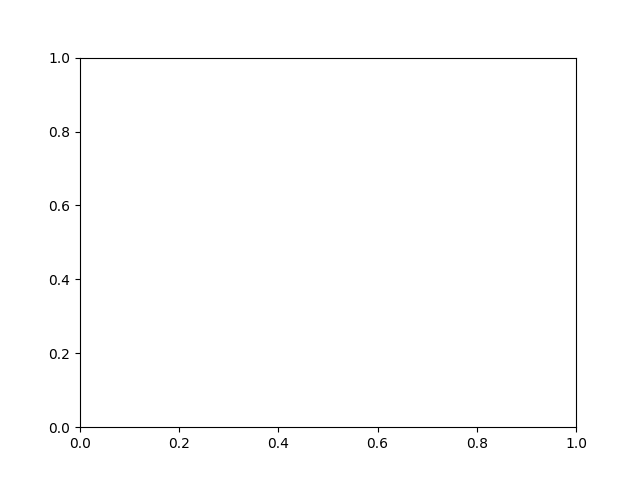

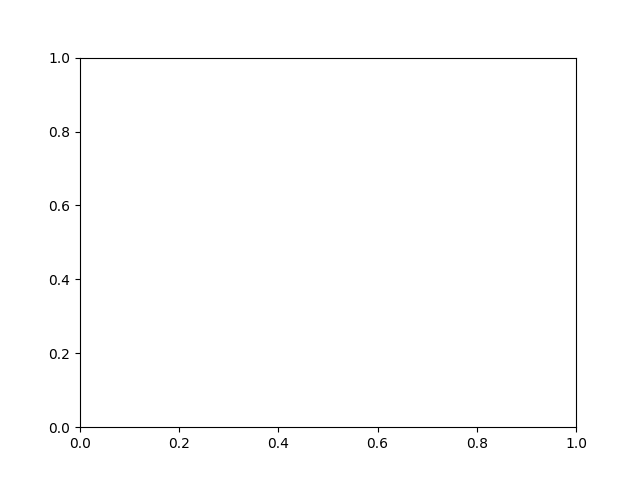

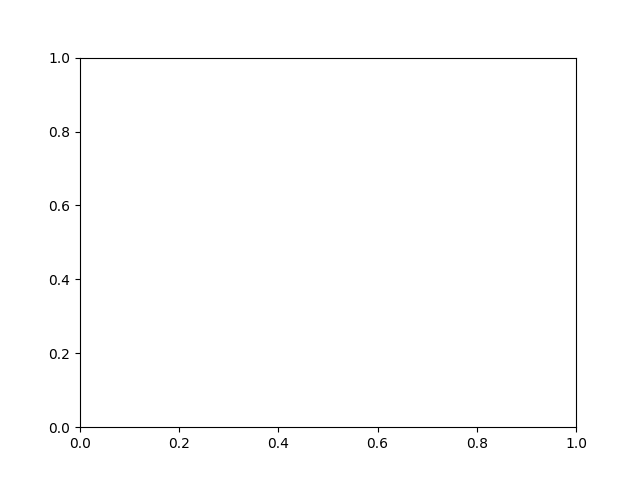

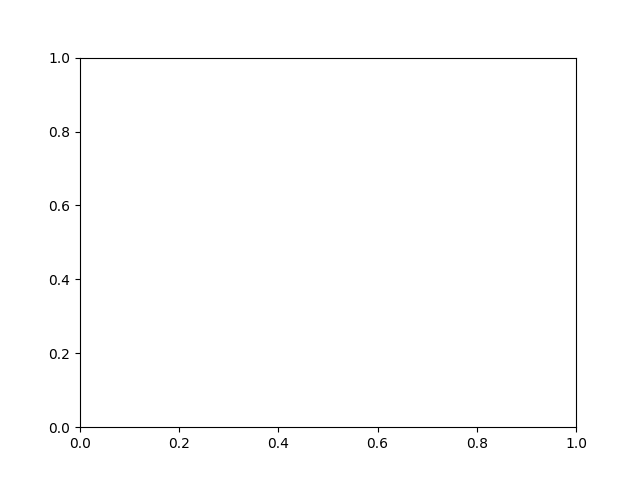

In [ ]:
if result['autoencoder']:
    # Plot Autoencoder Sensor Predictions if autoencoder is used
    fig7, ax7 = plt.subplots()
    fig8, ax8 = plt.subplots()
    fig9, ax9 = plt.subplots()
    fig10, ax10 = plt.subplots()

    # Create x-axis
    time_since_first = pd.read_csv(f"time_since_first_{result['hyperparams']['file']}.csv", header=0, names=['time_since_first'])
    time_since_first['time_since_first'] = pd.to_timedelta(time_since_first['time_since_first'])
    time_since_first['time_since_first'] = time_since_first['time_since_first'].dt.total_seconds()
    time_since_first = time_since_first.squeeze().to_numpy()
    x_true_list = all_results[0]['x_true_list']
    print(x_true_list)
    x_true_sensor_1 = x_true_list[0][0].copy()
    x_true_sensor_2 = x_true_list[0][1].copy()
    x_true_sensor_3 = x_true_list[0][2].copy()
    x_true_sensor_4 = x_true_list[0][3].copy()
    x_true_sensor_1 += [x_true[0][-1] for x_true in x_true_list[1:]]
    x_true_sensor_2 += [x_true[1][-1] for x_true in x_true_list[1:]]
    x_true_sensor_3 += [x_true[2][-1] for x_true in x_true_list[1:]]
    x_true_sensor_4 += [x_true[3][-1] for x_true in x_true_list[1:]]
    x_true_sensor_1 = x_true_sensor_1[300:350]
    x_true_sensor_2 = x_true_sensor_2[300:350]
    x_true_sensor_3 = x_true_sensor_3[300:350]
    x_true_sensor_4 = x_true_sensor_4[300:350]
    t_x = time_since_first[:len(x_true_sensor_1)]
            
    ax10.plot(t_x, x_true_sensor_4, label=f"Ground Truth {result['result_path'][18:]}", linestyle='--')
    ax9.plot(t_x, x_true_sensor_3, label=f"Ground Truth {result['result_path'][18:]}", linestyle='--')
    ax8.plot(t_x, x_true_sensor_2, label=f"Ground Truth {result['result_path'][18:]}", linestyle='--')
    ax7.plot(t_x, x_true_sensor_1, label=f"Ground Truth {result['result_path'][18:]}", linestyle='--')

    for result in all_results:
        
            x_pred_list = result['x_pred_list']

            # Unroll the sliding windows to get the predictions as a continuous list
            x_pred_sensor_1 = x_pred_list[0][0].copy()
            x_pred_sensor_2 = x_pred_list[0][1].copy()
            x_pred_sensor_3 = x_pred_list[0][2].copy()
            x_pred_sensor_4 = x_pred_list[0][3].copy()
            x_pred_sensor_1 += [x_pred[0][-1] for x_pred in x_pred_list[1:]]
            x_pred_sensor_2 += [x_pred[1][-1] for x_pred in x_pred_list[1:]]
            x_pred_sensor_3 += [x_pred[2][-1] for x_pred in x_pred_list[1:]]
            x_pred_sensor_4 += [x_pred[3][-1] for x_pred in x_pred_list[1:]]


            x_pred_sensor_1 = x_pred_sensor_1[300:350]
            x_pred_sensor_2 = x_pred_sensor_2[300:350]
            x_pred_sensor_3 = x_pred_sensor_3[300:350]
            x_pred_sensor_4 = x_pred_sensor_4[300:350]
            
            

            ax7.plot(t_x, x_pred_sensor_1, label=f"Prediction {result['result_path'][18:]}", marker=result['marker'])

            ax8.plot(t_x, x_pred_sensor_2, label=f"Prediction {result['result_path'][18:]}", marker=result['marker'])

            ax9.plot(t_x, x_pred_sensor_3, label=f"Prediction {result['result_path'][18:]}", marker=result['marker'])
            
            ax10.plot(t_x, x_pred_sensor_4, label=f"Prediction {result['result_path'][18:]}", marker=result['marker'])


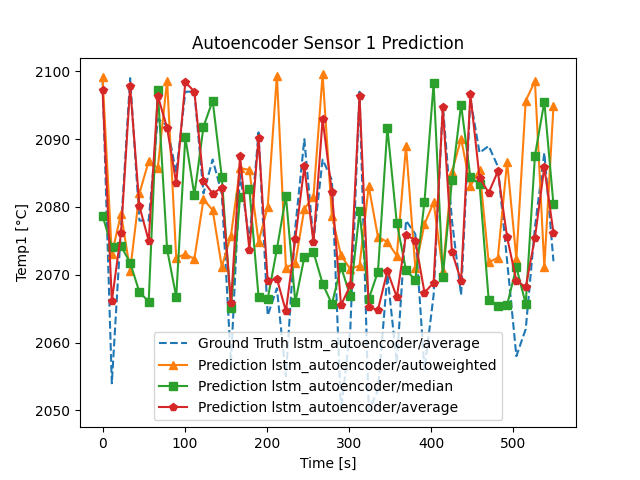

In [ ]:
if result['autoencoder']:
    ax7.set_title('Autoencoder Sensor 1 Prediction')
    ax7.set_xlabel('Time [s]')
    ax7.set_ylabel('Temp1 [°C]')
    ax7.legend()
    plt.savefig(path + 'temp1_comparison.png')  # Save the figure
    plt.show()

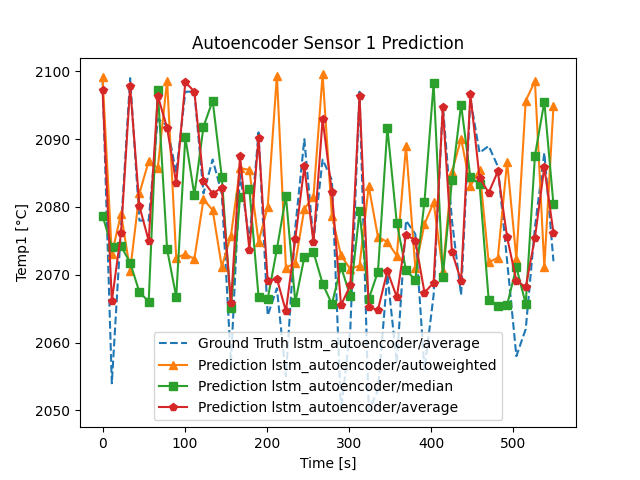

In [ ]:
if result['autoencoder']:
    ax8.set_title('Autoencoder Sensor 2 Prediction')
    ax8.set_xlabel('Time [s]')
    ax8.set_ylabel('Temp2 [°C]')
    ax8.legend()
    plt.savefig(path + 'temp2_comparison.png')  # Save the figure
    plt.show()

In [ ]:
if result['autoencoder']
    ax9.set_title('Autoencoder Sensor 3 Prediction')
    ax9.set_xlabel('Time [s]')
    ax9.set_ylabel('Temp3 [°C]')
    ax9.legend()
    plt.savefig(path + 'temp3_comparison.png')  # Save the figure
    plt.show()

SyntaxError: expected ':' (3245563646.py, line 1)

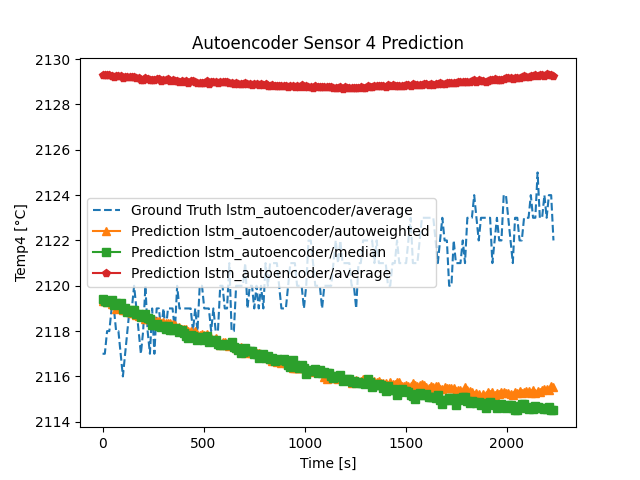

In [ ]:
if result['autoencoder']

    ax10.set_title('Autoencoder Sensor 4 Prediction')
    ax10.set_xlabel('Time [s]')
    ax10.set_ylabel('Temp4 [°C]')
    ax10.legend()
    plt.savefig(path + 'temp4_comparison.png')  # Save the figure
    plt.show()